IMPORT PLAY BY PLAY DATA FROM 2018-2023

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl

nfl_pbp = nfl.import_pbp_data([2023, 2022, 2021, 2020, 2019, 2018])

2023 done.
2022 done.
2021 done.
2020 done.
2019 done.
2018 done.
Downcasting floats.


EPA, SUCCESS RATE, EXPLOSIVE RATE at the Weekly/Seasonal Level for Offense & Defense

In [2]:
file_path = '/Users/markstolte/downloads/nfl_tendency.xlsx'
tendencies = pd.read_excel(file_path)
tendencies['proe'] = tendencies['proe']/100


In [3]:
file_path = '/Users/markstolte/downloads/nfelo_sos.xlsx'
sos = pd.read_excel(file_path)

In [4]:
pbp_rp = nfl_pbp[((nfl_pbp['pass'] == 1) | (nfl_pbp['rush'] == 1))].copy()


pbp_rp.loc[pbp_rp['pass'] == 1, 'pass_success'] = (pbp_rp['epa'] > 0)
pbp_rp.loc[pbp_rp['rush'] == 1, 'rush_success'] = (pbp_rp['epa'] > 0)
pbp_rp['pass_success'] = pbp_rp['pass_success'].astype(bool) # To remove warnings
pbp_rp['rush_success'] = pbp_rp['rush_success'].astype(bool)

pbp_rp['explosive_play'] = ((pbp_rp['pass'] == 1) | (pbp_rp['rush'] == 1)) & (pbp_rp['yards_gained'] > 20)



pass_epa = pbp_rp[pbp_rp['pass'] == 1].groupby(['posteam', 'season', 'week'])['epa'].mean().reset_index(name='pass_epa')
rush_epa = pbp_rp[pbp_rp['rush'] == 1].groupby(['posteam', 'season', 'week'])['epa'].mean().reset_index(name='rush_epa')
pass_sr = pbp_rp[pbp_rp['pass'] == 1].groupby(['posteam', 'season', 'week'])['pass_success'].mean().reset_index(name='pass_sr')
rush_sr = pbp_rp[pbp_rp['rush'] == 1].groupby(['posteam', 'season', 'week'])['rush_success'].mean().reset_index(name='rush_sr')
explosive_rate = pbp_rp.groupby(['posteam', 'season', 'week'])['explosive_play'].mean().reset_index(name='explosive_rate')
def_pass_sr = pbp_rp[pbp_rp['pass'] == 1].groupby(['defteam', 'season', 'week'])['pass_success'].mean().reset_index(name='def_pass_sr')
def_pass_sr.rename(columns={'defteam': 'posteam'}, inplace=True)
def_rush_sr = pbp_rp[pbp_rp['rush'] == 1].groupby(['defteam', 'season', 'week'])['rush_success'].mean().reset_index(name='def_rush_sr')
def_rush_sr.rename(columns={'defteam': 'posteam'}, inplace=True)
def_explosive_rate = pbp_rp.groupby(['defteam', 'season', 'week'])['explosive_play'].mean().reset_index(name='def_explosive_rate')
def_explosive_rate.rename(columns={'defteam': 'posteam'}, inplace=True)
def_pass_epa = pbp_rp[pbp_rp['pass'] == 1].groupby(['defteam', 'season', 'week'])['epa'].mean().reset_index(name='def_pass_epa')
def_pass_epa.rename(columns={'defteam': 'posteam'}, inplace=True)
def_rush_epa = pbp_rp[pbp_rp['rush'] == 1].groupby(['defteam', 'season', 'week'])['epa'].mean().reset_index(name='def_rush_epa')
def_rush_epa.rename(columns={'defteam': 'posteam'}, inplace=True)


In [5]:
from functools import reduce

dfs = [pass_epa, rush_epa, def_pass_epa, def_rush_epa, pass_sr, rush_sr, explosive_rate, def_pass_sr, def_rush_sr, def_explosive_rate]

stats = reduce(lambda left, right: pd.merge(left, right, on=['posteam', 'season', 'week'], how='left'), dfs)

stats = stats.reset_index(drop=True)

EWMA (EXPONENTIALLY WEIGHTED MOVING AVERAGE) OF NFL STATS

In [6]:
alpha = 0.11


ewma_stats = stats.copy()

columns_to_smooth = ['pass_epa', 'rush_epa', 'pass_sr', 'rush_sr', 'explosive_rate',
                     'def_pass_epa', 'def_rush_epa', 'def_pass_sr', 'def_rush_sr', 'def_explosive_rate']

for col in columns_to_smooth:
    ewma_stats[col] = stats.groupby(['posteam', 'season'])[col].transform(lambda x: x.ewm(alpha=alpha, adjust=False).mean())


last_week = ewma_stats.groupby(['posteam', 'season'])['week'].transform('max')

# Filter the DataFrame to keep only rows with the last week
ewma_stats = ewma_stats[ewma_stats['week'] == last_week]

# Reset index if needed
ewma_stats = ewma_stats.reset_index(drop=True)


DATA ON TEAM PERFORMANCE (WINNING)

In [7]:
season_data = nfl.import_schedules([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010])


# Replace team names
season_data['home_team'] = season_data['home_team'].replace({'OAK': 'LV', 'SD': 'LAC'})
season_data['away_team'] = season_data['away_team'].replace({'OAK': 'LV', 'SD': 'LAC'})

# Calculate home and away wins
season_data['home_win'] = np.where(season_data['home_score'] > season_data['away_score'], 1, 0)
season_data['away_win'] = np.where(season_data['away_score'] > season_data['home_score'], 1, 0)

# Get unique teams
teams = pd.concat([season_data['home_team'], season_data['away_team']]).unique()

# Initialize an empty DataFrame to store win statistics
win_stats = pd.DataFrame()

def calculate_stats(team):
    team_games = season_data[(season_data['home_team'] == team) | (season_data['away_team'] == team)]

    games_played = team_games.groupby('season').size()
    total_wins = team_games[((team_games['home_team'] == team) & (team_games['home_score'] > team_games['away_score'])) |
                            ((team_games['away_team'] == team) & (team_games['away_score'] > team_games['home_score']))].groupby('season').size()

    # Ensure total_wins has the same index as games_played, filling with zeros if necessary
    total_wins = total_wins.reindex(games_played.index, fill_value=0)

    return pd.DataFrame({
        'season': games_played.index,
        'team': team,
        'games_played': games_played.values,
        'total_wins': total_wins.values
    })

# Concatenate statistics for all teams
win_stats = pd.concat([calculate_stats(team) for team in teams], ignore_index=True)

# Calculate win percentage
win_stats['win_percentage'] = win_stats['total_wins'] / win_stats['games_played']

# Rename the team column to posteam
win_stats.rename(columns={'team': 'posteam'}, inplace=True)



df = pd.merge(ewma_stats, win_stats, on=['posteam', 'season'])

In [8]:
df = pd.merge(df, tendencies, on=['posteam', 'season'], how='left')

In [9]:
df = pd.merge(df, sos, on=['posteam', 'season'], how='left')

PYTHGOREAN EXPECTATION

In [10]:
season_data = season_data[season_data['week'] < 19]


points_for = (season_data.groupby(['season', 'home_team'])['home_score'].sum() +
              season_data.groupby(['season', 'away_team'])['away_score'].sum())

points_against = (season_data.groupby(['season', 'home_team'])['away_score'].sum() +
                  season_data.groupby(['season', 'away_team'])['home_score'].sum())


points_df = pd.DataFrame({
    'points_for': points_for,
    'points_against': points_against
}).reset_index()



In [11]:

def pythagorean_expectation(points_for, points_against):
    return (points_for ** 2.37) / (points_for ** 2.37 + points_against ** 2.37) * 17

points_df['pythag_wins'] = pythagorean_expectation(points_df['points_for'], points_df['points_against'])





In [12]:

df = df.merge(points_df[['season', 'home_team', 'pythag_wins']], 
              left_on=['season', 'posteam'], 
              right_on=['season', 'home_team'], 
              how='left')


df.drop(columns=['home_team'], inplace=True)



EXPLORATORY DATA ANALYSIS

In [13]:
df_2023 = df[df['season'] == 2023].copy()

df = df[df['season'] != 2023].copy()

df = df.sort_values(by=['posteam', 'season'])

lagged_df = df.copy()
lagged_columns = df.columns.difference(['posteam', 'season', 'win_percentage', #'pythag_wins'
                                        ])
lagged_df[lagged_columns] = df.groupby('posteam')[lagged_columns].shift(1)


lagged_df = lagged_df.dropna()



In [14]:
columns_to_ignore = ['season', 'games_played', 'total_wins', 'posteam', 'week', 
                     'unique_id', 'team_nick', 'team_name', 'team_logo_espn', 
                     'team_color']

lagged_df= lagged_df.drop(columns=columns_to_ignore, errors='ignore')

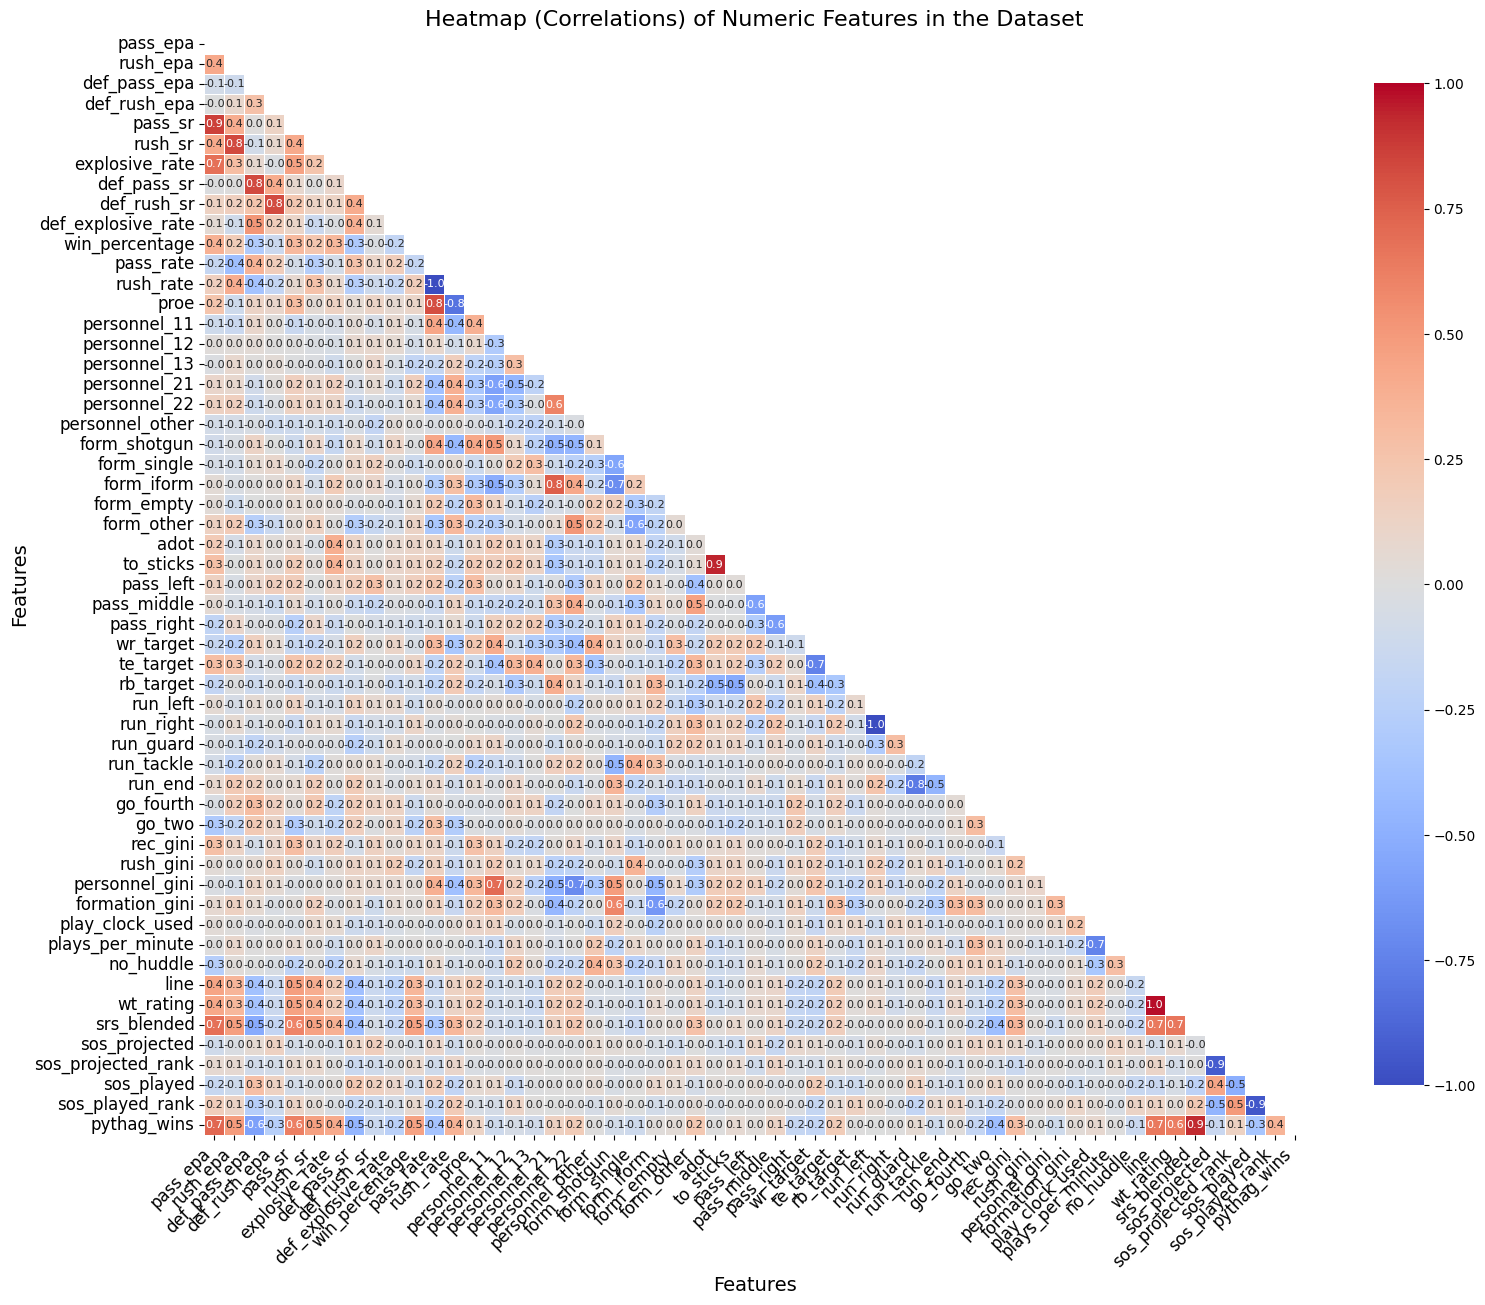

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'lagged_df' is your DataFrame

# Drop non-numeric columns or columns you don't want to include in the correlation matrix
columns_to_drop = ['season', 'games_played', 'total_wins', 'posteam', 'week']
lagged_df_cleaned = lagged_df.drop(columns=columns_to_drop, errors='ignore')

# Select only numeric columns for the correlation matrix
lagged_df_numeric = lagged_df_cleaned.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = lagged_df_numeric.corr()

# Create a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Generate the correlation matrix heatmap using Seaborn
plt.figure(figsize=(16, 14))  # Increase figure size
sns.heatmap(correlation_matrix, mask=mask, vmax=1, center=0, vmin=-1, square=True,
            cmap='coolwarm', linewidths=0.5, annot=True, annot_kws={"size": 8}, fmt='.1f',
            cbar_kws={"shrink": .8})

# Rotate the x and y axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.title('Heatmap (Correlations) of Numeric Features in the Dataset', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [24]:
import pandas as pd
import numpy as np

# Assuming 'lagged_df' is your DataFrame

# Drop non-numeric columns or columns you don't want to include in the correlation matrix
columns_to_drop = ['season', 'games_played', 'total_wins', 'posteam', 'week']
lagged_df_cleaned = lagged_df.drop(columns=columns_to_drop, errors='ignore')

# Select only numeric columns for the correlation matrix
lagged_df_numeric = lagged_df_cleaned.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = lagged_df_numeric.corr()

# Get correlations with 'win_percentage'
corr_with_target = correlation_matrix['win_percentage']

# Filter features that correlate with 'win_percentage' at least 0.3
selected_features = corr_with_target[abs(corr_with_target) >= 0.25].index

# Remove 'win_percentage' from the selected features for the next steps
selected_features = selected_features.drop('win_percentage')

# Create a new correlation matrix with the selected features
filtered_corr_matrix = correlation_matrix.loc[selected_features, selected_features]

# Remove features that correlate more than 0.6 with each other, keeping the one with the higher correlation to 'win_percentage'
while True:
    # Find pairs of features with correlation > 0.6
    high_corr_pairs = [(col, idx) for col in filtered_corr_matrix.columns for idx in filtered_corr_matrix.index 
                       if col != idx and abs(filtered_corr_matrix.loc[idx, col]) > 0.75]
    
    if not high_corr_pairs:
        break
    
    # Determine which feature to drop
    to_drop = None
    for col, idx in high_corr_pairs:
        if abs(corr_with_target[col]) >= abs(corr_with_target[idx]):
            to_drop = idx
        else:
            to_drop = col
        
        # Drop the feature with the lower correlation to 'win_percentage'
        filtered_corr_matrix = filtered_corr_matrix.drop(to_drop, axis=0).drop(to_drop, axis=1)
        break

# The remaining columns are the selected features
final_selected_features = filtered_corr_matrix.columns
print("Selected features:", final_selected_features)


Selected features: Index(['pass_epa', 'explosive_rate', 'def_pass_sr', 'line', 'pythag_wins'], dtype='object')


PREDICTION_MODEL

In [31]:
from pycaret.regression import *

data = lagged_df[['pythag_wins', 'pass_epa', 'win_percentage', 'rush_sr', 'explosive_rate', 'def_pass_sr']]


exp = setup(data=data, target='win_percentage', session_id=123, remove_multicollinearity= True, normalize= True )

best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,win_percentage
2,Target type,Regression
3,Original data shape,"(120, 6)"
4,Transformed data shape,"(120, 6)"
5,Transformed train set shape,"(84, 6)"
6,Transformed test set shape,"(36, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.1373,0.0247,0.1554,0.0556,0.1065,0.3887,0.0180
rf,Random Forest Regressor,0.1387,0.0254,0.1580,0.0449,0.1083,0.4045,0.0320
br,Bayesian Ridge,0.1372,0.0264,0.1585,0.0407,0.1092,0.4124,0.0090
ridge,Ridge Regression,0.1380,0.0271,0.1607,0.0092,0.1109,0.4082,0.0100
et,Extra Trees Regressor,0.1359,0.0254,0.1578,0.0041,0.1078,0.3948,0.0350
lr,Linear Regression,0.1383,0.0272,0.1612,0.0032,0.1112,0.4084,0.6740
lar,Least Angle Regression,0.1383,0.0272,0.1612,0.0032,0.1112,0.4084,0.1920
huber,Huber Regressor,0.1399,0.0276,0.1625,-0.0159,0.1121,0.4114,0.0190
omp,Orthogonal Matching Pursuit,0.1426,0.0283,0.1630,-0.0225,0.1116,0.4275,0.0090
lightgbm,Light Gradient Boosting Machine,0.1492,0.0299,0.1679,-0.0593,0.1149,0.4425,0.0960


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1210,0.0230,0.1518,0.3558,0.0973,0.2473
1,0.1263,0.0195,0.1397,0.3073,0.0977,0.3450
2,0.1418,0.0245,0.1566,0.4470,0.1072,0.3691
3,0.1286,0.0230,0.1515,0.2052,0.1058,0.3787
4,0.1287,0.0237,0.1540,0.2037,0.1086,0.5585
Mean,0.1293,0.0228,0.1507,0.3038,0.1033,0.3797
Std,0.0069,0.0017,0.0058,0.0927,0.0048,0.1008


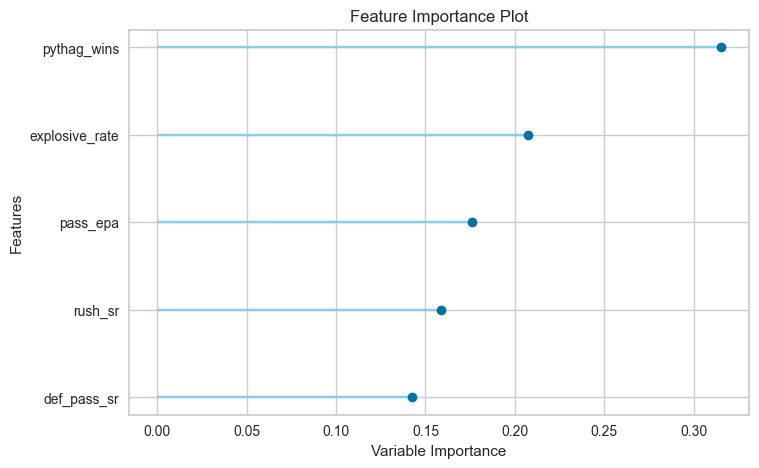

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['pythag_wins', 'pass_epa',
                                              'rush_sr', 'explosive_rate',
                                              'def_pass_sr'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('remove_multicollinearity',
                  TransformerWrapper(exclude=[],
                                     transformer=RemoveMulticollinearity(threshold=0.9))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('trained_model',
                  RandomForestRegressor(n_jobs=-1, random_state=123))]),
 'ada.pkl')

In [33]:
rf = create_model('rf', fold=5)
plot_model(rf, 'feature')

# Save the model
save_model(rf, 'ada')

In [27]:
# Load the Excel file
file_path = '/Users/markstolte/downloads/NFL_2024.xlsx'
projections = pd.read_excel(file_path)

In [34]:
import pandas as pd
from pycaret.regression import *

# Load your dataset
# Assuming 'lagged_df' is your DataFrame

# Set up the PyCaret environment for regression
reg_setup = setup(data=data, target='win_percentage', session_id=123)

# Load the pre-trained RandomForest model (make sure it's a regression model)
rf_model = load_model('rf')

# Assuming 'projections' is your DataFrame with new data for prediction
# Perform predictions using the loaded model
predictions = predict_model(rf_model, data=projections)




,Description,Value
0,Session id,123
1,Target,win_percentage
2,Target type,Regression
3,Original data shape,"(120, 6)"
4,Transformed data shape,"(120, 6)"
5,Transformed train set shape,"(84, 6)"
6,Transformed test set shape,"(36, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


Transformation Pipeline and Model Successfully Loaded


In [35]:
predictions

,team,pythag_wins,explosive_rate,pass_epa,rush_sr,def_pass_sr,prediction_label
0,ARI,5.41,0.05,-0.04,0.39,0.51,0.401978
1,ATL,7.00,0.05,-0.02,0.35,0.41,0.304950
2,BAL,13.34,0.06,0.15,0.42,0.41,0.555515
3,BUF,12.02,0.04,0.11,0.45,0.45,0.495471
4,CAR,3.52,0.02,-0.22,0.37,0.44,0.323707
5,CHI,7.98,0.05,-0.04,0.38,0.43,0.450172
6,CIN,8.02,0.05,-0.01,0.34,0.46,0.449664
7,CLE,9.40,0.05,-0.13,0.38,0.38,0.502630
8,DAL,12.87,0.05,0.25,0.43,0.47,0.559791
9,DEN,7.05,0.04,0.02,0.40,0.45,0.512810
